<a href="https://colab.research.google.com/github/MrSpecks/MrSpecks-/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [33]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64  # smaller batch size might help
epochs = 25      # increase epochs
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-07-15 19:26:33--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M  95.2MB/s    in 0.7s    

2025-07-15 19:26:33 (95.2 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
import os, shutil

test_subdir = os.path.join(test_dir, 'unknown')
os.makedirs(test_subdir, exist_ok=True)

for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    dest_path = os.path.join(test_subdir, filename)
    if os.path.isfile(file_path) and not os.path.exists(dest_path):
        shutil.move(file_path, test_subdir)


In [36]:
# 3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators with only rescaling
train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

# Generate batches of tensor image data for training
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Validation data
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Test data — must be placed inside a subdirectory, e.g., 'test/unknown'
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


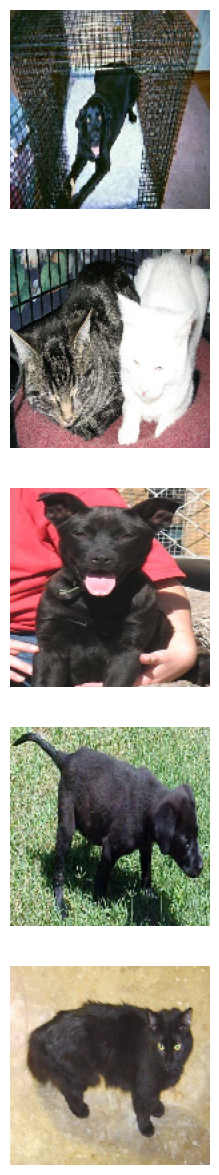

In [37]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [38]:
# 5

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


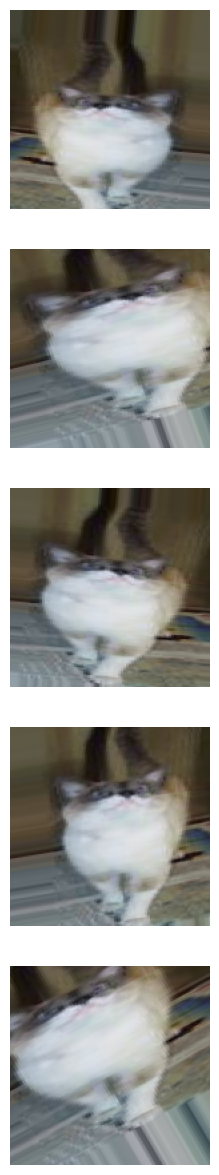

In [39]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/tmp/ipython-input-40-1033840720.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
#8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)



Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6064 - loss: 0.8499 - val_accuracy: 0.9156 - val_loss: 0.2498
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - accuracy: 0.7188 - loss: 0.4846 - val_accuracy: 0.9167 - val_loss: 0.2453
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8205 - loss: 0.4031 - val_accuracy: 0.9260 - val_loss: 0.1906
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.8750 - loss: 0.3512 - val_accuracy: 0.9260 - val_loss: 0.1898
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8482 - loss: 0.3402 - val_accuracy: 0.9385 - val_loss: 0.1654
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.8438 - loss: 0.3254 - val_accuracy: 0.9427 - val_loss: 0.1598
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8598 - loss: 0.3124 - val_accuracy: 0.9469 - val_loss: 0.1515
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - accuracy: 0.8125 - loss: 0.4005 - val_accuracy: 0.94

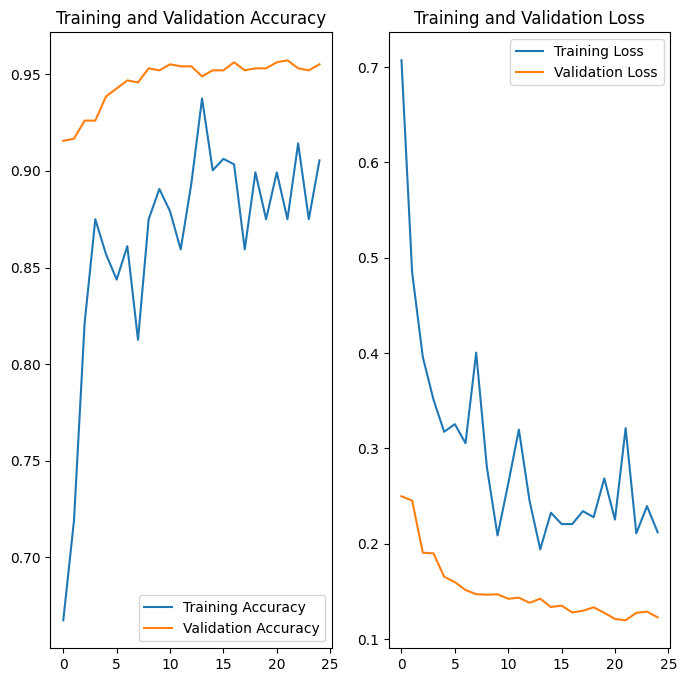

In [42]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


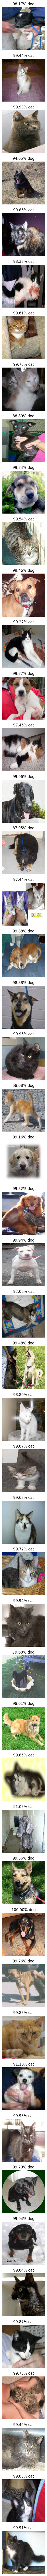

In [43]:
# Get the test images from the generator (batch of images)
test_images = next(test_data_gen)  # no unpacking needed

# Use the model to predict probabilities for the batch of test images
probabilities = model.predict(test_images)

# Since model outputs probabilities as floats between 0 and 1, flatten to 1D list
probabilities = probabilities.flatten().tolist()

# Plot the test images with their corresponding predicted probabilities
plotImages(test_images, probabilities)


In [44]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 92.0% of the images of cats and dogs.
You passed the challenge!
